In [ ]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image


In [ ]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'

def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'


def generate_actual_predicted(Y_pred, X_test, Y_test):
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))

    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))

    return actual, predicted

In [ ]:
image_folder_path = '/content/drive/MyDrive/SpectogramInitial'

file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [ ]:
X_all = []
Y_all = []

file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2)
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))

In [ ]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = to_categorical(Y_all, num_classes=8)

(3018, 112, 170, 3)
(3018,)


In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/Bats_AUS/X_all.npy', X_all)
np.save('/content/drive/MyDrive/Colab Notebooks/Bats_AUS/Y_all.npy', Y_all)

In [ ]:
X_all = np.load('/content/drive/MyDrive/Colab Notebooks/Bats_AUS/X_all.npy')
Y_all = np.load('/content/drive/MyDrive/Colab Notebooks/Bats_AUS/Y_all.npy')
print(X_all.shape)
print(Y_all.shape)

(3018, 112, 170, 3)
(3018, 8)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)

In [ ]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
model = build_current_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 170, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 56, 85, 56)        8288      
                                                                 
 batch_normalization (Batch  (None, 56, 85, 56)        224       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 56, 85, 56)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 43, 56)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 28, 43, 56)        0     

In [ ]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]


In [ ]:
history = model.fit(X_train, Y_train,
            batch_size=8,
            epochs=100,
            verbose=2,
            callbacks=my_callbacks)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Bats_AUS/saved_model_19feb')


In [ ]:
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/Colab Notebooks/Bats_AUS/saved_model_19feb'
model = load_model(model_path)

19/19 [==============================] - 5s 228ms/step
Test loss: 0.07170522958040237 / Test accuracy: 0.9817880988121033
Confusion Matrix:
[[  5   0   0   0   0   0   0   0]
 [  0  24   0   0   1   0   0   0]
 [  0   0  22   0   0   0   0   0]
 [  0   0   0  59   1   0   0   0]
 [  0   0   0   0 331   0   1   1]
 [  0   0   0   0   0  53   1   0]
 [  0   0   1   1   1   0  21   0]
 [  0   0   1   0   1   0   1  78]]
Classification Report:
               precision    recall  f1-score   support

    A.tridens     1.0000    1.0000    1.0000         5
     E.bottae     1.0000    0.9600    0.9796        25
M.emarginatus     0.9167    1.0000    0.9565        22
      P.kuhli     0.9833    0.9833    0.9833        60
R.muscatellum     0.9881    0.9940    0.9910       333
    R.nasutus     1.0000    0.9815    0.9907        54
  R.aegyptius     0.8750    0.8750    0.8750        24
 T.perforatus     0.9873    0.9630    0.9750        81

     accuracy                         0.9818       604
    

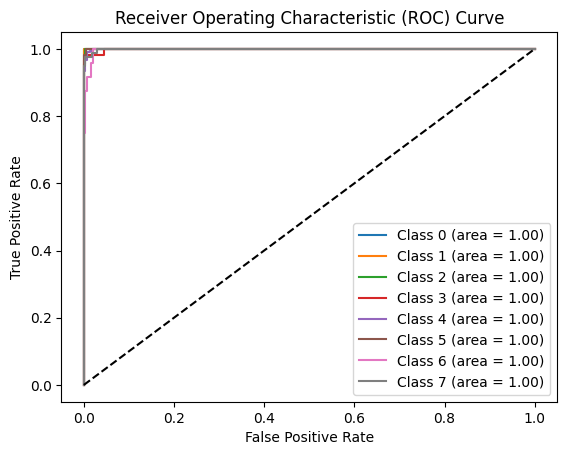

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Assuming your model is saved as 'model.h5' and can be loaded as follows:
# model = load_model('model.h5')

# Class labels
labels = ['A.tridens', 'E.bottae', 'M.emarginatus', 'P.kuhli', 'R.muscatellum', 'R.nasutus', 'R.aegyptius', 'T.perforatus']


# Predict classes and probabilities for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

# For binary classification, adjust the shape of y_pred to match y_true
if y_pred.shape[1] == 1:
    y_pred = y_pred.ravel()

# Test scores
test_scores = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {test_scores[0]} / Test accuracy: {test_scores[1]}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report (Precision, Recall, F1-Score)
print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=labels, digits=4))


# AUROC (Area Under the Receiver Operating Characteristic curve)
# Note: For multi-class, consider using a one-vs-rest approach
if len(Y_test[0]) == 2:  # Binary classification
    roc_auc = roc_auc_score(Y_test, y_pred)
    print(f'AUROC: {roc_auc}')
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, label=f'AUROC (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
else:  # Multi-class classification
    # Compute ROC curve and ROC area for each class
    n_classes = Y_test.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


[[1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.96 0.   0.   0.04 0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.98 0.02 0.   0.   0.  ]
 [0.   0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.98 0.02 0.  ]
 [0.   0.   0.04 0.04 0.04 0.   0.88 0.  ]
 [0.   0.   0.01 0.   0.01 0.   0.01 0.96]]


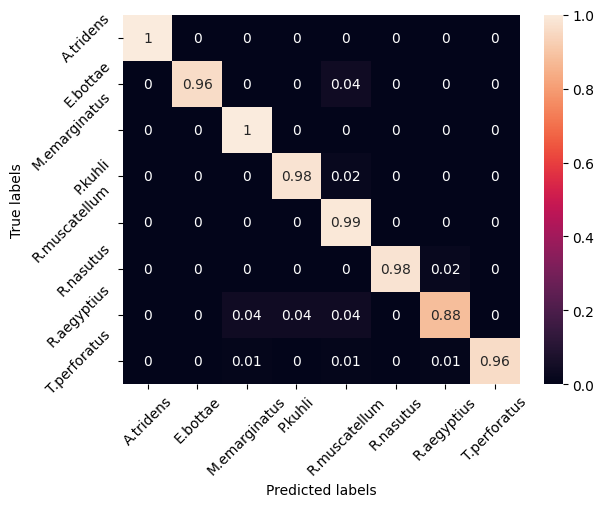

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= conf_matrix/ conf_matrix.sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
# ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);
plt.savefig('bat_confusion_mat.pdf', bbox_inches="tight")